
### Introduction

A reminder of what our initial model looked like:
<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq1.png" alt="mlp" align="middle"></center>

In this architecture, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

The preparation is the same as last time. **TODO** Please copy over your completed code in the areas marked TODO from the previous notebook.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import os
SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.deterministic = True

In [0]:
%%capture
! python -m spacy download en
! python -m spacy download de
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [3]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
#   TODO fill in from the previous notebook
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True, include_lengths=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), fields=(SRC, TRG))
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TODO complete from the previou snotebook
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size=BATCH_SIZE,
     sort_key = lambda x : len(x.src),
     device=device, sort_within_batch=True)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 486kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 167kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 163kB/s]


**TODO** The encoder is the same as part 1. Please fill in the code below

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        #    TODO fill in from the previous notebook 
        self.embedding = nn.Embedding(input_dim, emb_dim)
        #    TODO fill in from the previous notebook     
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        #    TODO fill in from the previous notebook 
        self.fc = nn.Linear(2 * enc_hid_dim, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        #     TODO
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        
        packed_outputs, hidden = self.rnn(packed_embedded)

        #     TODO
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards encoder RNNs fed through a linear layer
        #TODO:
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
                       
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention


I would strongly recommend reading through [this tutorial](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) on attention (You can skip the parts on neural turing machines and self-attentive gans). We will be implementing the additive attention mention in that tutorial and which is described below. 

<br/>

The goal of the attention layer is to help the model better decide which tokens from the input are most important at the current decoding timestep. The attention layer will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1. Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

<br/>

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch, as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of this as calculating a weighted sum of the "match" over all `dec_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq9.png" alt="mlp" align="middle"></center>



<br/>

#### Implementation

**TODO**: 
Here you will implement the attention mechanism. Notice how we will pass a mask to the attention layer. When we were writing the torchtext code, we decided to use "include_lengths" in the source field to keep track of the varied lengths of all the source examples and to pad them accordingly. Now we want to use that information to "mask," or set to zero, those entries in the source tensor which correspond to padding and not actual input. We don't want to pay attention to padded zeros! 

In the implementation below, *hidden* is equal to $s_{t-1}$ refereneced above and *encoder_outputs* is equivalent to the H matrix. Sizes of these tensors are specified in the code. There is a **TODO** flag in the line right before every line which you have to modify in the code and are numbered accordingly: 


1.  For the *hidden* tensor, add a dimension between batch_size and dec_hid_dim and  repeat this dimension for src_len times. Look at the [unsqueeze](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.unsqueeze) and [repeat](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.repeat) functions in torch documentation. 

2. Currently the dimensions of encoder_outputs are (src sent len, batch size, enc hid dim x 2) but we ultimately want the dimensions to be (batch size, src sent len, enc hid dim x 2) for matrix multiplication so use the [permute function](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.permute) to switch these dimensions. 


3.  Energy is currently this size: (batch size, src sent len, dec hid dim) and we want it to be of size (batch size, dec hid dim, src sent len). Use the permute function to swap the dimensions. 

4. Matrix multiple v and energy and then squeeze the middle dimension. Look at [torch.mm](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.mm) and [torch.bmm](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.bmm) and determine which is appropriate to use for matrix multiplication here. 

In [0]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2] --
        # it contains the hidden states (bidirectional) over the entire src sentence
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        #    TODO 1:
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        #    TODO 2: 
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        # This implements the equation for energy in the notes above
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
        # TODO 3: 
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        # repeat v to allow for matrix multiplication
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
        # TODO 4: 
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        # mask the padded input indices
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.

<center><img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/master/assets/seq2seq10.png" alt="mlp" align="middle"></center>

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

**TODO**

As above,  the TODO in the decoder code are numbered: 

1. Using the same function for matrix multiplication as above, matrix multiple *a* and *encoder_outputs*. Also, in your README, reiterate how **a** from the equations above can be understood as encoding the importance of words in the source and how this matrix multiplication incorporates this into the modified hidden state (put this as Q3).

2. Concatenate *embedded* and *weighted* along their last dimension. Look at the torch function [*cat*](https://pytorch.org/docs/stable/torch.html#torch.cat). 


In [0]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        # TODO 1: 
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        # TODO 2: 
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all(), print(output.shape, hidden.shape, output[0,0,:25], hidden[0,0,:25])
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

This seq2seq encapsulator is similar to the last notebook, except that we also return attention scores with the decoder. Also, we slightly refactored the code to allow an inference mode (when we want to predict in a real-world setting and return as soon as we predict the end-of-sentence token).

Briefly going over all of the decoding steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            inference = True
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            trg = torch.zeros((100, src.shape[1]), dtype=torch.long).fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

In [8]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
PAD_IDX = SRC.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

20518917

In [0]:
optimizer = optim.Adam(model.parameters())

In [0]:
pad_idx = TRG.vocab.stoi['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, src_len, trg)
        
        loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output, _ = model(src, src_len, trg, 0) #turn off teacher forcing

            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))

            epoch_loss += loss.item()
        

        return epoch_loss / len(iterator)

**TODO** Train the model for 5 epochs and then report your results in the README

In [13]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
  
N_EPOCHS = 5
CLIP = 10
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'tut4_model.pt')

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    


Epoch: 01 | Time: 0m 35s
	Train Loss: 4.460 | Train PPL:  86.447
	 Val. Loss: 4.239 |  Val. PPL:  69.365
Epoch: 02 | Time: 0m 35s
	Train Loss: 3.565 | Train PPL:  35.336
	 Val. Loss: 3.844 |  Val. PPL:  46.730
Epoch: 03 | Time: 0m 35s
	Train Loss: 3.135 | Train PPL:  22.998
	 Val. Loss: 3.781 |  Val. PPL:  43.872
Epoch: 04 | Time: 0m 35s
	Train Loss: 2.873 | Train PPL:  17.685
	 Val. Loss: 3.621 |  Val. PPL:  37.370
Epoch: 05 | Time: 0m 35s
	Train Loss: 2.622 | Train PPL:  13.762
	 Val. Loss: 3.617 |  Val. PPL:  37.228


In [14]:
SAVE_DIR = 'models'
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'tut4_model.pt')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.613 | Test PPL:  37.061 |


### Inference and Visualizing Attention

After you've trained your model, you want to get an idea of how well it's doing by seeing actual translations! Please take a look at the translate_sentence function, which takes a German sentence as input and returns the translation and attention scores. The attention scores correspond to the scores at each time step for every word in the input. This allows you to visualize what words the model was weighting the most during decoding and thus offers some notion of interpretability (you can see what is important for your model's predictions). This is often visualized as a heatmap (see example below).The code is commented to guide you. 

In [0]:
def translate_sentence(sentence):
    tokenized = tokenize_de(sentence) #tokenize sentence
    tokenized = ['<sos>'] + [t.lower() for t in tokenized] + ['<eos>'] #add <sos> and <eos> tokens and lowercase
    numericalized = [SRC.vocab.stoi[t] for t in tokenized] #convert tokens into indexes
    sentence_length = torch.LongTensor([len(numericalized)]).to(device) #need sentence length for masking
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) #convert to tensor and add batch dimension
    translation_tensor_probs, attention = model(tensor, sentence_length, None, 0) #pass through model to get translation probabilities
    translation_tensor = torch.argmax(translation_tensor_probs.squeeze(1), 1) #get translation from highest probabilities
    translation = [TRG.vocab.itos[t] for t in translation_tensor][1:] #ignore the first token, just like we do in the training loop
    return translation, attention[1:] #ignore first attention array

In [0]:
def display_attention(candidate, translation, attention):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    attention = attention[:len(translation)].squeeze(1).cpu().detach().numpy() #cut attention to same length as translation
    cax = ax.matshow(attention, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in tokenize_de(candidate)] + ['<eos>'], rotation=90)
    ax.set_yticklabels([''] + translation)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

# TODO

1. Find a German sentence from Google Translate (or any other source) and try translating it to English with our system. Add the model's translation as well as Google's translation to your README. We are training for a very short time and on very little data, so we can't expect good results, but see if what parts our model is able to correctly translate. 

2. Use display_attention to visualize the attention heatmap for your example. 

In [23]:
# candidate = ' '.join(vars(valid_data.examples[0])['src'])
# candidate_translation = ' '.join(vars(valid_data.examples[0])['trg'])
candidate = "Am Ende geht die Sonne auf"
candidate_translation = "In the end the sun rises"

print(candidate)
print(candidate_translation)

Am Ende geht die Sonne auf
In the end the sun rises


The heamap below shows German along the x-axis and the model's English translation along the y axis. Each row shows you what words in the German sentence our system was giving the most attention weight to as a particular step in decoding. In the example below, you can see that our model correctly assigns weigth to the German word *gruppe* when decoding *a group*.

['the', 'train', 'is', 'the', 'the', 'on', 'the', '.', '.']


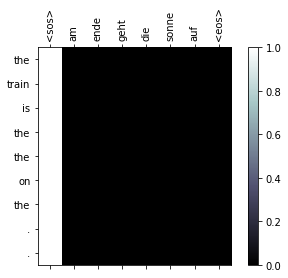

In [24]:
translation, attention = translate_sentence(candidate)

print(translation)

display_attention(candidate, translation, attention)

## Submission

Now that you have completed the assignment, follow the steps below to submit your aissgnment:
1. Click __Runtime__  > __Run all__ to generate the output for all cells in the notebook.
2. Save the notebook with the output from all the cells in the notebook by click __File__ > __Download .ipynb__.
3. Copy model train and test prints, answers to all short questions, and the shareable link of this notebook to a `README.txt` file.
4. Put the .ipynb file and `README.txt` under your hidden directory on the Zoo server `~/hidden/<YOUR_PIN>/Homework4/`.
5. As a final step, run a script that will set up the permissions to your homework files, so we can access and run your code to grade it. Make sure the command runs without errors, and do not make any changes or run the code again. If you do run the code again or make any changes, you need to run the permissions script again. Submissions without the correct permissions may incur some grading penalty.
`/home/classes/cs477/bash_files/hw4_set_permissions.sh <YOUR_PIN>`